mapdata_copyright_openstreetmap_contributors.rds
mapdata_copyright_openstreetmap_contributors.txt
noaa_weather_qclcd_documentation.pdf
sampleSubmission.csv
spray.csv
test.csv
train.csv
weather.csv



/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:245: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


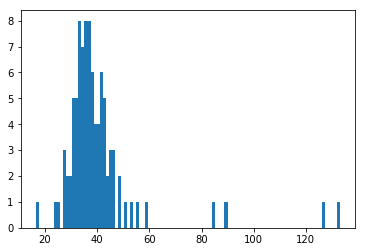

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import gpxpy.geo
from datetime import datetime

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

#TODO: add variable names for each category

###################################### reading files
def readfile(filename,offset=0):
    f = open(filename, 'r')
    data =[]
    for i,line in enumerate(f):
        line = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '',line)
        if i == 0:
            labels = line.strip().replace('\"','').split(",")
        if i > 0: 
            data += [line.strip().replace('\"','').split(",")]
    return labels[offset:], np.array(data)[:,offset:]

sprayfile = "../input/spray.csv"
weatherfile = "../input/weather.csv" 
trainfile = "../input/train.csv"
testfile = "../input/test.csv"

spraylabels,spray = readfile(sprayfile)
weatherlabels,weather = readfile(weatherfile)
trainlabels,train = readfile(trainfile)
testlabels,test = readfile(testfile,1)


########################################### create dictionaries for categorical vars
# find indeces for aggregations - and build dictionaries {[key,indeces in train/test sets]}
def indeces(dataset):
    addressIndeces = {}
    speciesIndeces = {}
    dateIndeces = {}
    for i,line in enumerate(dataset):
        address = line[1]
        date = line[0].replace('/', '-')
        species = line[2]
        if address in addressIndeces: addressIndeces[address] += [i]
        else: addressIndeces[address] = [i]
        if species in speciesIndeces: speciesIndeces[species] += [i]
        else: speciesIndeces[species] = [i]
        if date in dateIndeces: dateIndeces[date] += [i]
        else: dateIndeces[date] = [i]
    return addressIndeces,speciesIndeces,dateIndeces
    
TrainaddressIndeces,TrainspeciesIndeces,TraindateIndeces = indeces(train)
TestaddressIndeces,TestspeciesIndeces,TestdateIndeces = indeces(test)



############################################################### do a stupid clustering on sites
############################################################### TODO: make it smarter
x = np.array(train[:,11],dtype=int) # Y variable
N = len(train)
Ntest = len(test)

NInf = sum(x)
d = 10 # number of site cohorots
dn = np.ceil(NInf/d-1) # #infections in each cohorot

n = len(TrainaddressIndeces) # number of different addresses
addressCohorot = np.zeros([n,2],dtype='int32') # for each address in TrainaddressIndeces find the sum(x) and put them in an array [sum(x),var_number]
addressSums = {} # {(key in TrainaddressIndeces):sum(x)}
for i,key in enumerate(TrainaddressIndeces):
    sumx = np.sum(x[TrainaddressIndeces[key]])
    addressCohorot[i,0] = sumx 
    addressSums[key] = sumx

addressCohorot = addressCohorot[(-addressCohorot[:,0]).argsort(),:] # sort addressCohorot in descending order by sum(x) over the site address

## assign category number for each
s = 0
category = 0
for i in range(n):
    s += addressCohorot[i,0]
    if addressCohorot[i,0] >= dn:
        addressCohorot[i,1] = category
        category += 1
        s = 0
        continue
    elif s >= dn:
        category += 1
        s = 0
    addressCohorot[i,1] = category

#################################################################### create categorical var for site clusters on train/test clusters
addressCategory = {}
XCohorot = np.zeros([N,d])
XCohorottest = np.zeros([Ntest,d]) 
for i,key in enumerate(TrainaddressIndeces):
    # XCohorot at the indeces of this category and the column equal to the allocated cohorot should be 1
    category = addressCohorot[np.where(addressCohorot[:,0]==addressSums[key])[0],1][0]
    addressCategory[key] = category
    XCohorot[TrainaddressIndeces[key],category] = 1
    if TestaddressIndeces.get(key) != None:
        XCohorottest[TestaddressIndeces[key],category] = 1
		
		
############################################################ create var for each site with the distance to main two addresses
		
addressCordinates = {} # dict with {address:array([latitude,longitude])} of all sites
for k, v in TrainaddressIndeces.items():
	addressCordinates[k] = np.array(train[v[0],[7,8]],dtype=float)
for k, v in TestaddressIndeces.items():
	if k not in addressCordinates:
		addressCordinates[k] = np.array(test[v[0],[7,8]],dtype=float)
	
#extract the outlier addresses
outbreaks = {} # dict with {address:array([latitude,longitude])} of outbreak sites
for k, v in addressSums.items(): 
	if v > 30: # manual condition for outbreak. TODO: update if needed
		outbreaks[k] = addressCordinates[k]

outbreaksDist = {}
for address, cordinates in addressCordinates.items():
	d = []
	for OBaddress, OBcordinates in outbreaks.items():
		if address == OBaddress:
			d += [0]
		else:
			d += [gpxpy.geo.haversine_distance(cordinates[0],cordinates[1],OBcordinates[0],OBcordinates[1])]
	outbreaksDist[address] = np.array(d,dtype=float)


Xoutbreaks = np.zeros([N,len(outbreaks)])
Xoutbreakstest = np.zeros([Ntest,len(outbreaks)])
for k, v in TrainaddressIndeces.items():
	Xoutbreaks[v,:] = (outbreaksDist[k]/1000)**2
for k, v in TestaddressIndeces.items():
	Xoutbreakstest[v,:] = (outbreaksDist[k]/1000)**2

############################################################ create var for mosquito species

##### classify species to 4 categories:
#CULEX PIPIENS/RESTUANS 0
#CULEX RESTUANS 1
#CULEX PIPIENS 2
#CULEX SALINARIUS 3
#CULEX TERRITANS 3
#CULEX TARSALIS 3
#CULEX ERRATICUS 3

XSpecis = np.zeros([N,4])
for k,v in TrainspeciesIndeces.items():
	if k == "CULEX PIPIENS/RESTUANS": XSpecis[v,0] = 1
	elif k == "CULEX RESTUANS": XSpecis[v,1] = 1
	elif k == "CULEX PIPIENS": XSpecis[v,2] = 1
	else:  XSpecis[v,3] = 1

XSpecistest = np.zeros([Ntest,4])
for k,v in TestspeciesIndeces.items():
	if k == "CULEX PIPIENS/RESTUANS": XSpecistest[v,0] = 1
	elif k == "CULEX RESTUANS": XSpecistest[v,1] = 1
	elif k == "CULEX PIPIENS": XSpecistest[v,2] = 1
	else:  XSpecistest[v,3] = 1
	
############################################################ climate variables - only based on station1
weather0  = weather[weather[:,0]=='1'] # only station 1
dates = weather0[:,1]
vars = [4,6,7,10,11,17,19,21]
for v in vars:
	weather0[np.where(weather0[:,v]=='M')[0],v]='-1'
	
sunset_minutes = np.array(weather0[:,[11]],dtype=float)
sunrise_minutes = np.array(weather0[:,[10]],dtype=float)
sunset_minutes = np.floor(sunset_minutes/100) * 60 + (sunset_minutes%100)
sunrise_minutes = np.array(weather0[:,[10]],dtype=float)
sunrise_minutes = np.floor(sunrise_minutes/100) * 60 + (sunrise_minutes%100)
daylight_minutes = sunset_minutes - sunrise_minutes # sunset - sunrise times

windows = [1,7,28]
other_vars = np.array(weather0[:,[4,6,7,17,19,21]],dtype=float) 
XweatherRaw = np.hstack([other_vars,daylight_minutes])
nw,dw = np.shape(XweatherRaw)
dwMA = dw * len(windows)
XweatherMA = np.zeros([nw,dwMA],dtype=float)
XweatherMAcol = 0
for var in range(dw):
	for line in range(nw):
		if XweatherRaw[line,var] == -1:
			if line == 0: XweatherRaw[line,var] = XweatherRaw[line+1,var]
			elif line == nw-1: XweatherRaw[line,var] = XweatherRaw[line-1,var]
			else: XweatherRaw[line,var] = (XweatherRaw[line-1,var] + XweatherRaw[line+1,var])/2
	for window in windows:
		XweatherMA[:,XweatherMAcol] = np.convolve(XweatherRaw[:,var], np.ones((window,))/window, mode='full')[:nw]
		XweatherMAcol += 1

# move data in XweatherMA to X variables according to the dates
XweatherNonLinear = np.zeros([N,dwMA],dtype=float)
XweatherNonLineartest = np.zeros([Ntest,dwMA],dtype=float)
for i,d in enumerate(dates):
	if d in TraindateIndeces: 
		XweatherNonLinear[TraindateIndeces[d],:] = XweatherMA[i,:]
	if d in TestdateIndeces: 
		XweatherNonLineartest[TestdateIndeces[d],:] = XweatherMA[i,:]

# produce categorical variables for linear models
quantiles = range(10,100,10)
dwMAInd = dwMA * (1+len(quantiles))
XweatherMAInd = np.zeros([nw,dwMAInd],dtype=float) # dividing XweatherMA for 10 quantiles indicators per each line
XweatherMAIndcol = 0
for var in range(dwMA):
	quant_prev = -float("inf") #previous quantie in the loop
	for q in quantiles:
		quant = np.percentile(XweatherMA[:,var],q)
		XweatherMAInd[ (XweatherMA[:,var]>quant_prev)*(XweatherMA[:,var]<quant) , XweatherMAIndcol] = 1
		XweatherMAIndcol += 1
		quant_prev = quant
	quant = float("inf")
	XweatherMAInd[ np.where((XweatherMA[:,var]>quant_prev)*(XweatherMA[:,var]<quant))[0] , XweatherMAIndcol] = 1
	XweatherMAIndcol += 1

# move data in XweatherMAIndcol to X variables according to the dates
XweatherLinear = np.zeros([N,dwMAInd],dtype=float)
XweatherLineartest = np.zeros([Ntest,dwMAInd],dtype=float)
for i,d in enumerate(dates):
	if d in TraindateIndeces: 
		XweatherLinear[TraindateIndeces[d],:] = XweatherMAInd[i,:]
	if d in TestdateIndeces: 
		XweatherLineartest[TestdateIndeces[d],:] = XweatherMAInd[i,:]	


############################################################ spray variables

dists = []
prevLine = None
for line in spray:
	if prevLine == None: 
		prevLine = line
		continue
	if line[0] == prevLine[0]:
		dists += [gpxpy.geo.haversine_distance(float(line[2]),float(line[3]),float(prevLine[2]),float(prevLine[3]))]
		prevLine = line

plt.hist(dists,bins = 100) 
# base on this, I choose 100meters as the radius of full effect, and after this it start decaying

SprayEfforts = {} # a dict of {date:[all locations]}
for line in spray:
	date = line[0]
	coordinates = (float(line[2]),float(line[3]))
	if date in SprayEfforts: SprayEfforts[date] += [coordinates]
	else: SprayEfforts[date] = [coordinates]

addressSprayEfforts = {} # a dict of dicts: {site:{Spraydate:minDist}} where the value refers to spraying in the area of at most 1KM to the site
for kaddress,vCordinate in addressCordinates.items():
	SprayEffortsPeraddress = {}
	for SprayDate,SprayLocations in SprayEfforts.items():
		minDist = float("inf")
		for SprayCoordinates in SprayLocations:
			dist = gpxpy.geo.haversine_distance(float(vCordinate[0]),float(vCordinate[1]),float(SprayCoordinates[0]),float(SprayCoordinates[1]))
			if dist < min(minDist,1000):
				minDist = dist
				SprayEffortsPeraddress[SprayDate] = minDist
				addressSprayEfforts[kaddress] = SprayEffortsPeraddress
